In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
u_var = '10m_u_component_of_wind'
v_var = '10m_v_component_of_wind'
year = 2020

# Load ERA5

In [5]:
process_era5 = era5.ProcessERA5()

u_era5_var = VAR_ERA5[u_var]['var_name']
u_era5_ds = process_era5.load_ds(u_var, year)
u_era5_ds = u_era5_ds.compute()

v_era5_var = VAR_ERA5[v_var]['var_name']
v_era5_ds = process_era5.load_ds(v_var, year)
v_era5_ds = v_era5_ds.compute()

# Load stations

In [20]:
process_stations = stations.ProcessStations()

u_station_var = VAR_STATIONS[u_var]['var_name']
v_station_var = VAR_STATIONS[v_var]['var_name']
station_df = process_stations.load_stations(u_var, year, return_uv=True)

Filtering stations: 100%|██████████| 208/208 [00:43<00:00,  4.79it/s]


Concatenating stations into pd.DataFrame


In [22]:
station_df

u         v
time       station_name     latitude  longitude                    
2020-01-01 AKAROA EWS       -43.80938 172.96574  0.440524 -0.544002
           AKITIO EWS       -40.57728 176.44889  9.353074 -5.400000
           ALEXANDRA AWS    -45.21452 169.37549 -0.694073  1.423061
           ALEXANDRA CWS    -45.25366 169.39205 -0.281683  0.529769
           ALEXANDRA EWS    -45.25458 169.38448 -0.394205  1.026938
...                                                   ...       ...
2020-12-31 WHANGAREI EWS    -35.74440 174.32868 -1.685082  2.236179
           WHATAWHATA 2 EWS -37.78832 175.06906 -1.773803 -0.680899
           WHITIANGA EWS    -36.82817 175.67231 -2.779144 -2.591594
           WINCHMORE 2 EWS  -43.78935 171.79032 -3.011088 -3.344152
           WINDSOR EWS      -45.00829 170.82281 -2.035315 -1.271806

[1777624 rows x 2 columns]

In [23]:
len_df = len(station_df)
station_df = station_df.dropna(subset=[u_station_var, v_station_var])
print(f'Dropped {len_df - len(station_df)} NaN values')
station_df

Dropped 3706 NaN values


u         v
time       station_name     latitude  longitude                    
2020-01-01 AKAROA EWS       -43.80938 172.96574  0.440524 -0.544002
           AKITIO EWS       -40.57728 176.44889  9.353074 -5.400000
           ALEXANDRA AWS    -45.21452 169.37549 -0.694073  1.423061
           ALEXANDRA CWS    -45.25366 169.39205 -0.281683  0.529769
           ALEXANDRA EWS    -45.25458 169.38448 -0.394205  1.026938
...                                                   ...       ...
2020-12-31 WHANGAREI EWS    -35.74440 174.32868 -1.685082  2.236179
           WHATAWHATA 2 EWS -37.78832 175.06906 -1.773803 -0.680899
           WHITIANGA EWS    -36.82817 175.67231 -2.779144 -2.591594
           WINCHMORE 2 EWS  -43.78935 171.79032 -3.011088 -3.344152
           WINDSOR EWS      -45.00829 170.82281 -2.035315 -1.271806

[1773918 rows x 2 columns]

# Plots

In [26]:
u_era5_mean = float(u_era5_ds[u_era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
u_station_mean = np.mean(station_df[u_station_var].values)
print('U-component of wind:')
print(f'ERA5 overall mean: {u_era5_mean}, \nStation overall mean: {u_station_mean}')

v_era5_mean = float(v_era5_ds[v_era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
v_station_mean = np.mean(station_df[v_station_var].values)
print('V-component of wind:')
print(f'ERA5 overall mean: {v_era5_mean}, \nStation overall mean: {v_station_mean}')

U-component of wind:
ERA5 overall mean: 0.7898935079574585, 
Station overall mean: 0.5983607184566027
V-component of wind:
ERA5 overall mean: -0.4538993537425995, 
Station overall mean: -0.3556384142615051


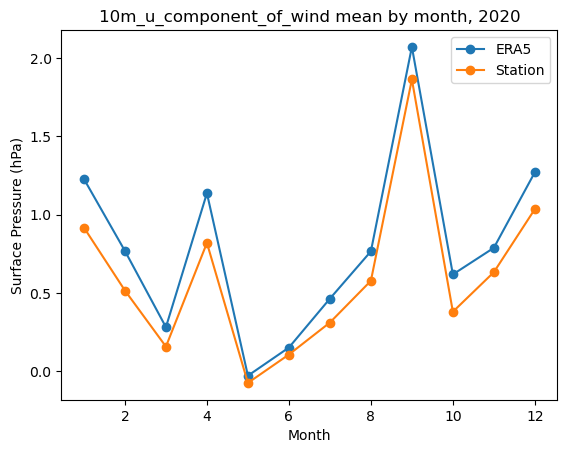

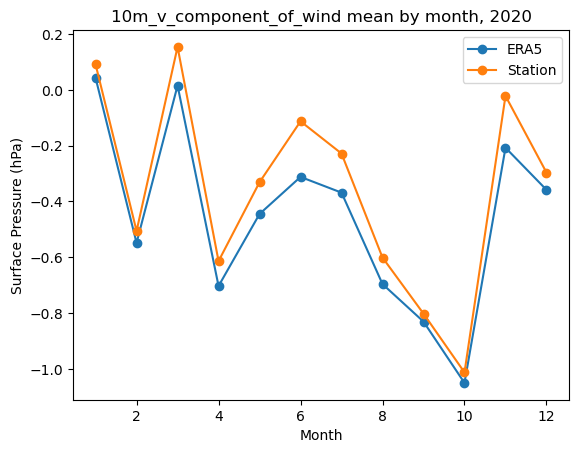

In [27]:
u_era5_mean_by_month = u_era5_ds[u_era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values

station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')
u_station_mean_by_month = station_df_reset[u_station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), u_era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), u_station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Surface Pressure (hPa)')
ax.legend()
ax.set_title(f'{u_var} mean by month, {year}')
plt.show();

v_era5_mean_by_month = v_era5_ds[v_era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values
v_station_mean_by_month = station_df_reset[v_station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), v_era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), v_station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Surface Pressure (hPa)')
ax.legend()
ax.set_title(f'{v_var} mean by month, {year}')
plt.show();


# By station

In [28]:
stations = station_df_reset['station_name'].unique()

In [29]:
u_stats_by_station = {}
v_stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    
    u_station_data_vals = station_data[u_station_var]
    u_station_mean = u_station_data_vals.mean()
    u_station_std = u_station_data_vals.std()

    u_era5_data = u_era5_ds[u_era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    u_era5_data_vals = u_era5_data.values
    u_era5_mean = u_era5_data_vals.mean()
    u_era5_std = u_era5_data_vals.std()

    u_stats_by_station[station] = {'station_mean': u_station_mean, 
                                 'station_std': u_station_std,
                                 'era5_mean': u_era5_mean,
                                 'era5_std': u_era5_std}

    v_station_data_vals = station_data[v_station_var]
    v_station_mean = v_station_data_vals.mean()
    v_station_std = v_station_data_vals.std()

    v_era5_data = v_era5_ds[v_era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                        longitude=station_data['longitude'].unique()[0],
                                        method='nearest')
    
    v_era5_data_vals = v_era5_data.values
    v_era5_mean = v_era5_data_vals.mean()
    v_era5_std = v_era5_data_vals.std()

    v_stats_by_station[station] = {'station_mean': v_station_mean,
                                    'station_std': v_station_std,
                                    'era5_mean': v_era5_mean,
                                    'era5_std': v_era5_std}

  0%|          | 0/207 [00:00<?, ?it/s]

100%|██████████| 207/207 [00:19<00:00, 10.78it/s]


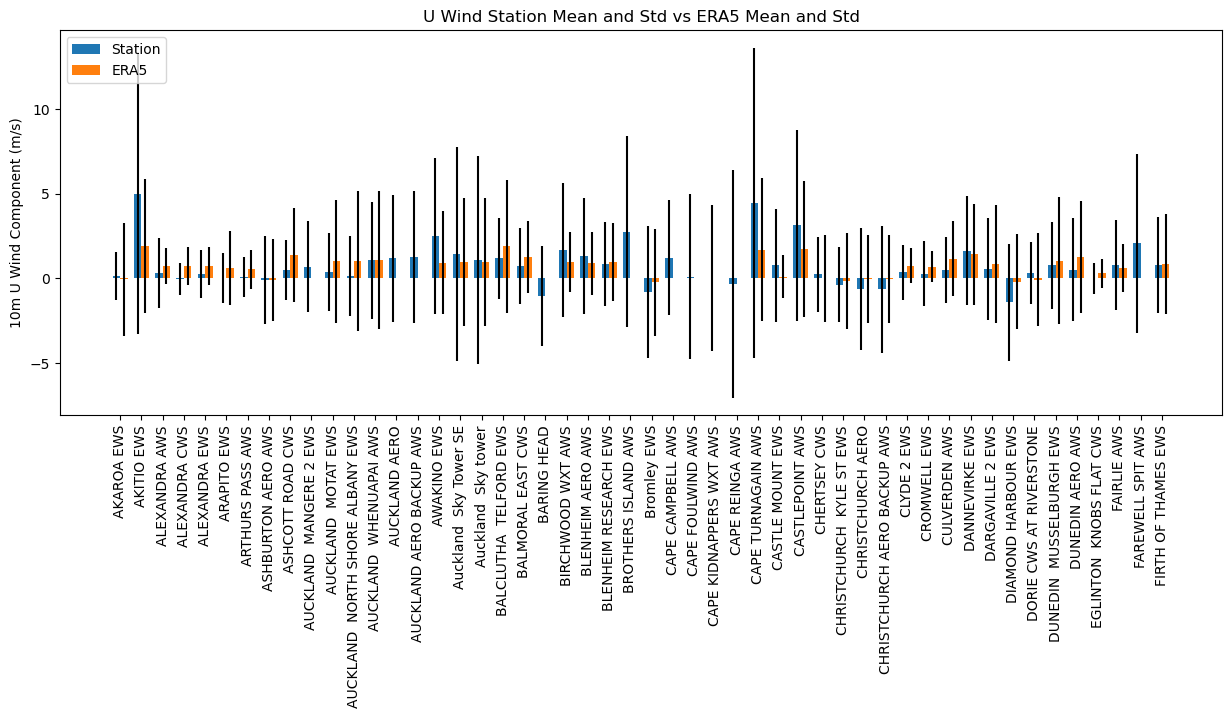

In [30]:
num_stations = len(u_stats_by_station)

station_names = list(u_stats_by_station.keys())

station_means = [u_stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [u_stats_by_station[station]['station_std'] for station in station_names]

era5_means = [u_stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [u_stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('10m U Wind Component (m/s)')
ax.set_title('U Wind Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

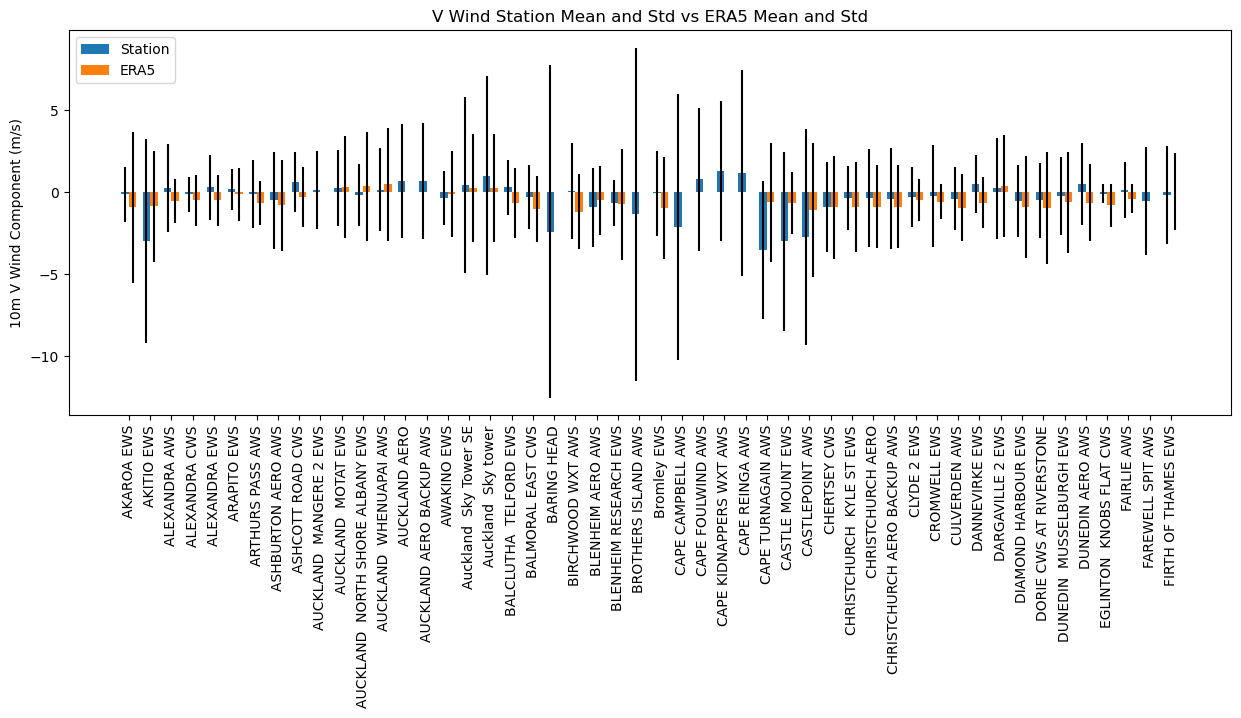

In [31]:
num_stations = len(v_stats_by_station)

station_names = list(v_stats_by_station.keys())

station_means = [v_stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [v_stats_by_station[station]['station_std'] for station in station_names]

era5_means = [v_stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [v_stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('10m V Wind Component (m/s)')
ax.set_title('V Wind Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

# Visualise

In [33]:
cmap = 'seismic'

### U Wind

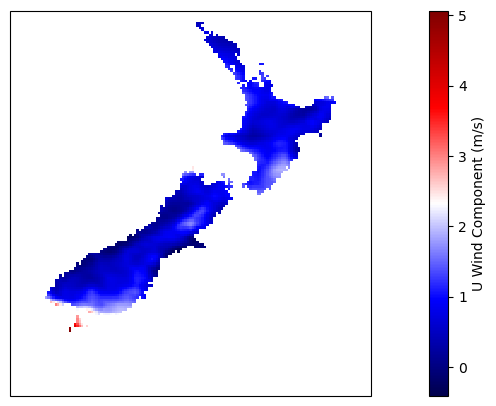

In [38]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = u_era5_ds[u_era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'U Wind Component (m/s)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

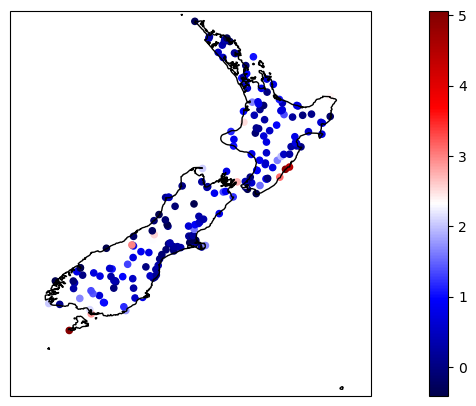

In [39]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[u_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

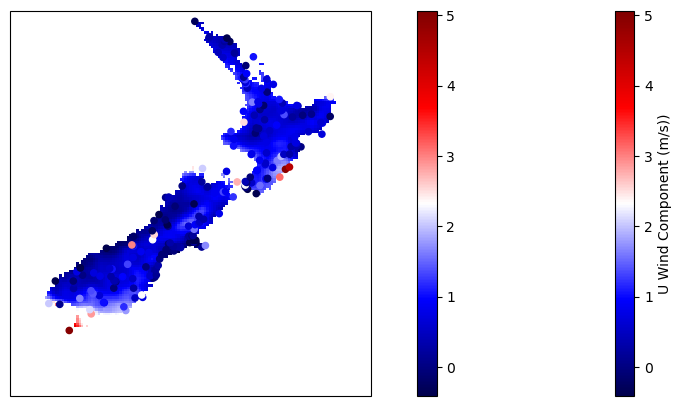

In [40]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'U Wind Component (m/s))'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[u_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


### V Wind

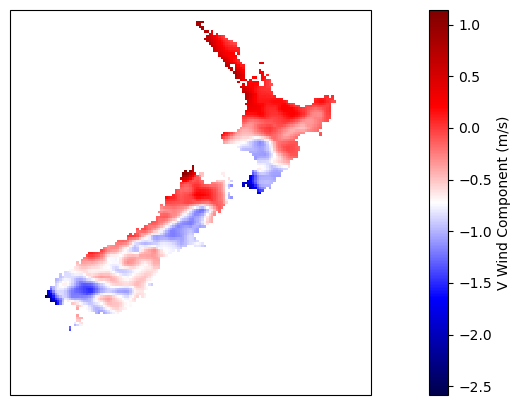

In [35]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = v_era5_ds[v_era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'V Wind Component (m/s)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

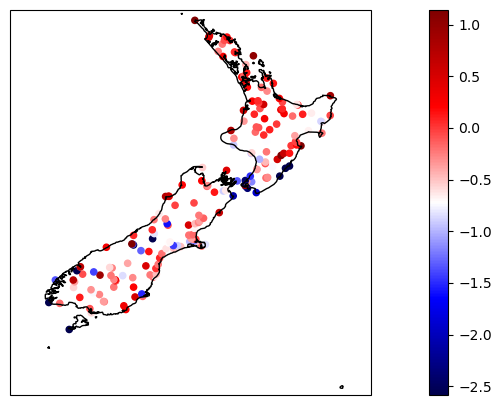

In [36]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[v_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

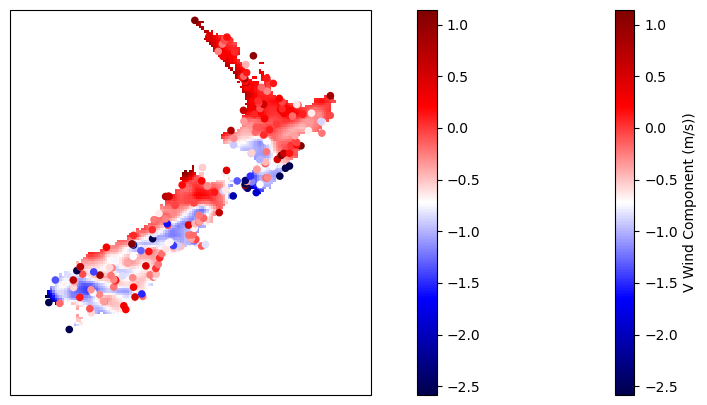

In [37]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'V Wind Component (m/s))'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[v_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())
